In many financial situations like default prediction, interpretable models are required. Linear models like 
logistic model are often used to reach the requirement. Meanwhile, in order to make the model robust, people
often apply single variable transformation like WOE. However, such transformation has two main drawbacks:

    1) It is sensitive to noise and sometimes yields transformed boxes which are not monotone.
    2) Because of the loss of monotonicity, interpretibility can not be guaranteed.
    
This repository introduce a new method of single variable transformation, which can ensure that the transformation
is monotone as well as continues.

The repository also presents LinearModel.py which offers a series of modified logistic models. 
The dome jupyter file shows that the modified methods outperforms the state of art logistic model in terms of accuracy 
and robustness.

*MonoLogitTrans.py* : 

    Description:
        The module offers an algorithm of single varaible transformation, which has following propertities:
            1) positively corelated with P(Y=1)
            2) offers paramater to choose if the transformation is guaranteed to be monotone
            3) theoretically equivalent to the logit of P(Y=1) 
        
        How:
            If the parameter method='wide':
                Fit MLP between single varaible and Y. The loss function is made up of two parts,
                cross entropy and loss of monotonicity.
                The difination of loss of monotonicity is:
                    $\text{loss_monotonous}(x,f(x)) = 1 - |(\rho(x,f(x)))|$
                    $\rho(x,y)$ is Pearson correlation coefficient.
                The final loss function is:
                    loss = cross_entropy($\sigma$(f(x)),y)+lambda_monotonous*loss_monotonous(x,f(x))
            If the parameter method='strict':
                The sign of all the weights in the same hiden layer are constrainted to be the same. Hence, the 
                MLP is nested function of monotone functions, which means that the MLP is a monotone function.
                In this situation, the loss function is simply the cross entropu loss.
    Version info：
        sklearn 0.20.1
        tensorflow 1.13.1
        python 3.7.1
        
*LinearModel.py* : 

    Description:
        The module offers a siries of class of logistic regression, which are similar to the logistic regressions offered
        by sklearn when people use them. For example, they have methods like fit(), predict(), predict_proba(), etc.
        The main modifications are:
            1）In order to cooperate with single variable transformations like WOE which are positively correlated with
               P(Y=1), the class PosLassoClassifier and PosLassoClassifierCV offers logistic regression with constraint 
               that all the coefficients are positive.
            2）They adopt SGD with choice of start point of ridge regression estimator or random normal.
            3) To deal with outliers, the loss of each batch can exclude the largest (1-Q0)*100% elements with label
               Y=0 and (1-Q1)*100% elements with label Y=1, before taking the mean, which makes the model nonsensitive
               of cost.
            4) The final estimator can be set to be the mean of estimated values of 100 iterations after converge, 
               in order to get a robust estimation and variable selection, which makes the model nonsensitive to 
               randomness of sampling.
    Version info：
        sklearn 0.20.1
        tensorflow 1.13.1
        matplotlib 3.0.2
        python 3.7.1

**This demo uses breast cancer data offered by sklearn to demonstrate how to use MonoLogitTrans.py to preform single variable transformation, as well as to use LinearModel.py to build binary classifier after that**

The main parts are:

1. Get data
2. Perform single varaible transformation with MonoLogitTrans
3. Modeling and comparision
4. Demonstrate the choice of start point of LinearModel
5. Demonstrate the choice of Q0 and Q1 of LinearModel

First, install the package [easylogistic](https://github.com/ModelerGuanxuSu/EasyLogistic/raw/master/easylogistic-1.0.1.tar.gz)

In [1]:
import easylogistic

import other packages

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import sklearn
from sklearn.linear_model import LogisticRegressionCV
import time

### Get Data

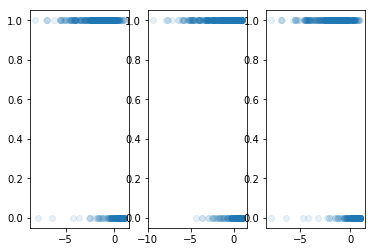

In [3]:
x1,x2,x3,x1_test,x2_test,x3_test,y,y_test = easylogistic.get_data()

plt.subplot(1,3,1)
plt.plot(x1,y,'o',alpha=0.1)
plt.subplot(1,3,2)
plt.plot(x2,y,'o',alpha=0.1)
plt.subplot(1,3,3)
plt.plot(x3,y,'o',alpha=0.1)
plt.show()

### Perform single varaible transformation with MonoLogitTrans

In [4]:
MonoLogitTrans1 = easylogistic.MonoLogitTrans(method='strict')
MonoLogitTrans2 = easylogistic.MonoLogitTrans(method='wide')
MonoLogitTrans3 = easylogistic.MonoLogitTrans(method='wide',num_hidden=30)
time1 = time.time()
MonoLogitTrans1.fit(x1,y)
MonoLogitTrans2.fit(x2,y)
MonoLogitTrans3.fit(x3,y)
time2 = time.time()
print(time2-time1)

x1_trans = MonoLogitTrans1.transform(x1_test)
x2_trans = MonoLogitTrans2.transform(x2_test)
x3_trans = MonoLogitTrans3.transform(x3_test)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
5.387627601623535


**Save and load parameters**

In [5]:
#save parameters
MonoLogitTrans1.save_parameter('./Docs/MonoLogitTrans1.txt')
MonoLogitTrans2.save_parameter('./Docs/MonoLogitTrans2.txt')
MonoLogitTrans3.save_parameter('./Docs/MonoLogitTrans3.txt')
#load parameters
MonoLogitTrans1_ = easylogistic.MonoLogitTrans()
MonoLogitTrans2_ = easylogistic.MonoLogitTrans()
MonoLogitTrans3_ = easylogistic.MonoLogitTrans()
MonoLogitTrans1_.load_parameter('./Docs/MonoLogitTrans1.txt')
MonoLogitTrans2_.load_parameter('./Docs/MonoLogitTrans2.txt')
MonoLogitTrans3_.load_parameter('./Docs/MonoLogitTrans3.txt')
x1_trans = MonoLogitTrans1_.transform(x1_test)
x2_trans = MonoLogitTrans2_.transform(x2_test)
x3_trans = MonoLogitTrans3_.transform(x3_test)

#### Make sure converge by looking at trace plot of loss

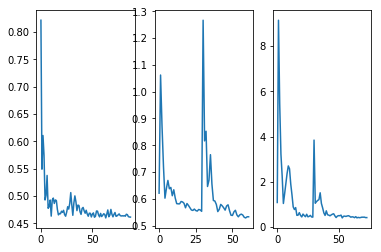

In [6]:
plt.subplot(1,3,1)
plt.plot(MonoLogitTrans1.Loss)
plt.subplot(1,3,2)
plt.plot(MonoLogitTrans2.Loss)
plt.subplot(1,3,3)
plt.plot(MonoLogitTrans3.Loss)
plt.show()

#### Comparision between original data (horizontal ordinate) and transformed data (vertical ordinate)

If method='wide', such as the last two varaibles, then the value of lambda_monotonous controls monotonicity.
The greater lambda_monotonous is, the more likely that the tranformation is monotone.

If method='strict', such as the first varaible, the tranformation would be guaranteed to be monotone.

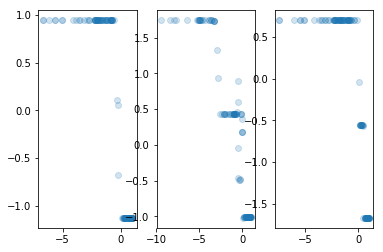

In [7]:
plt.subplot(1,3,1)
plt.plot(x1_test,x1_trans,'o',alpha=0.2)
plt.subplot(1,3,2)
plt.plot(x2_test,x2_trans,'o',alpha=0.2)
plt.subplot(1,3,3)
plt.plot(x3_test,x3_trans,'o',alpha=0.2)
plt.show()

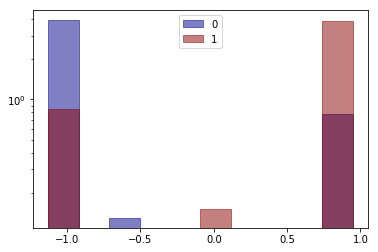

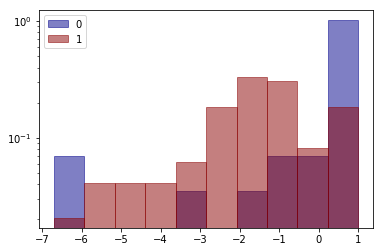

In [8]:
easylogistic.PlotComparableHistogram(variable_=pd.Series(x1_trans),lable_=pd.Series(y_test))
easylogistic.PlotComparableHistogram(variable_=pd.Series(x1_test),lable_=pd.Series(y_test))

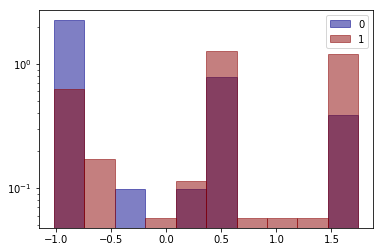

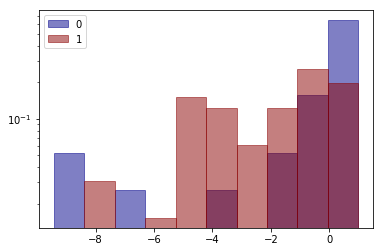

In [9]:
easylogistic.PlotComparableHistogram(variable_=pd.Series(x2_trans),lable_=pd.Series(y_test))
easylogistic.PlotComparableHistogram(variable_=pd.Series(x2_test),lable_=pd.Series(y_test))

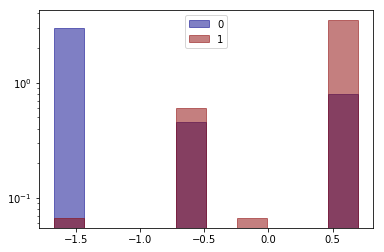

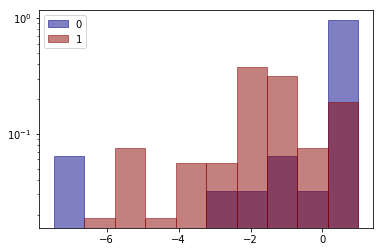

In [10]:
easylogistic.PlotComparableHistogram(variable_=pd.Series(x3_trans),lable_=pd.Series(y_test))
easylogistic.PlotComparableHistogram(variable_=pd.Series(x3_test),lable_=pd.Series(y_test))

#### Obtain the test set of original data and transformed data

In [11]:
x1_test = np.reshape(x1_test,(len(x1_test),1))
x2_test = np.reshape(x2_test,(len(x2_test),1))
x3_test = np.reshape(x3_test,(len(x3_test),1))
x1_trans = np.reshape(x1_trans,(len(x1_trans),1))
x2_trans = np.reshape(x2_trans,(len(x2_trans),1))
x3_trans = np.reshape(x3_trans,(len(x3_trans),1))

X_origin = np.concatenate((x1_test,x2_test,x3_test),axis=1)
X_trans = np.concatenate((x1_trans,x2_trans,x3_trans),axis=1)

### Modeling and comparision

Because all the transformed variables are positively correlated with P(y=1), it would be better to use PosLassoClassifierCV of LinearModel. 

For the original data, LogisticRegressionCV of sklearn is applied.

In [12]:
model1 = easylogistic.PosLassoClassifierCV(beta_mean=True)
model1.fit(X_trans,y_test)
model2 = LogisticRegressionCV(cv=5)
model2.fit(X_origin,y_test)

CV loop No.0 for lambda=0.01
2019-08/19/19 15:26:19	40	2.7226515
CV loop No.1 for lambda=0.01
2019-08/19/19 15:26:20	40	2.73356
CV loop No.0 for lambda=0.001
CV loop No.1 for lambda=0.001
2019-08/19/19 15:26:21	40	2.6877537
2019-08/19/19 15:26:21	60	2.67968
CV loop No.0 for lambda=0.0001
2019-08/19/19 15:26:21	40	2.6803575
2019-08/19/19 15:26:22	60	2.701406
2019-08/19/19 15:26:22	80	2.7099493
CV loop No.1 for lambda=0.0001
2019-08/19/19 15:26:22	40	2.7159274
CV loop No.0 for lambda=1e-05
CV loop No.1 for lambda=1e-05
CV loop No.0 for lambda=1e-06
2019-08/19/19 15:26:24	40	2.6964936
CV loop No.1 for lambda=1e-06
Set lambda=1e-06 and fit model...
2019-08/19/19 15:26:25	40	2.883686
Positive Lasso  picked 2 variables and eliminated the other 1 variables


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

#### Coefficients

In [13]:
model1.coef_

array([0.        , 1.25894856, 2.16166759])

In [14]:
model2.coef_[0]

array([-1.4170879 , -0.29881972,  0.61332106])

#### Prediction

In [15]:
y_hat_trans = model1.predict_proba(X_trans)[:,1]
y_hat_origin = model2.predict_proba(X_origin)[:,1]

In [16]:
from sklearn.metrics import roc_auc_score

In [17]:
roc_auc_score(y_test,y_hat_trans)

0.9579579579579578

In [18]:
roc_auc_score(y_test,y_hat_origin)

0.8601458601458601

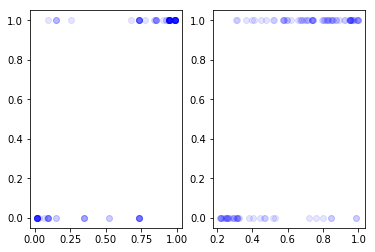

In [19]:
plt.subplot(1,2,1)
plt.plot(y_hat_trans,y_test,'bo',alpha=0.1)
plt.subplot(1,2,2)
plt.plot(y_hat_origin,y_test,'bo',alpha=0.1)
plt.show()

ks_value is 0.8095 at pop = 0.51


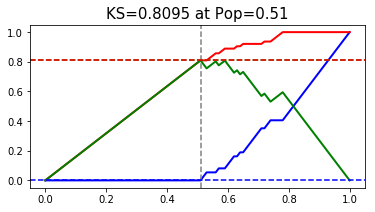

In [33]:
easylogistic.PlotKS(y_hat_trans,y_test)

ks_value is 0.668 at pop = 0.61


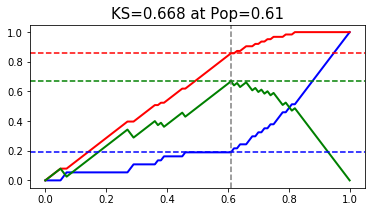

In [34]:
easylogistic.PlotKS(y_hat_origin,y_test)

## Demonstrate the choice of start point of LinearModel

In [22]:
model1 = easylogistic.LassoClassifierCV(beta_mean=True,start_point='ridge')
model1.fit(X_origin,y_test)
model2 = easylogistic.LassoClassifierCV(beta_mean=True,start_point=None)
model2.fit(X_origin,y_test)
y_hat_1 = model1.predict_proba(X_origin)[:,1]
y_hat_2 = model2.predict_proba(X_origin)[:,1]

CV loop No.0 for lambda=0.1
CV loop No.1 for lambda=0.1
2019-08/19/19 15:26:27	40	4.824548
2019-08/19/19 15:26:27	60	4.786458
2019-08/19/19 15:26:27	80	4.8132653
CV loop No.0 for lambda=0.01
2019-08/19/19 15:26:28	40	4.744507
CV loop No.1 for lambda=0.01
2019-08/19/19 15:26:28	40	4.6868443
2019-08/19/19 15:26:28	60	4.648049
2019-08/19/19 15:26:28	80	4.723716
CV loop No.0 for lambda=0.001
2019-08/19/19 15:26:29	40	4.6434007
2019-08/19/19 15:26:29	60	4.622667
2019-08/19/19 15:26:29	80	4.636047
2019-08/19/19 15:26:29	100	4.6401753
CV loop No.1 for lambda=0.001
2019-08/19/19 15:26:29	40	4.641471
CV loop No.0 for lambda=0.0001
2019-08/19/19 15:26:30	40	4.780905
CV loop No.1 for lambda=0.0001
2019-08/19/19 15:26:30	40	4.6508427
2019-08/19/19 15:26:30	60	4.6312623
2019-08/19/19 15:26:30	80	4.6279564
2019-08/19/19 15:26:31	100	4.674889
CV loop No.0 for lambda=1e-05
2019-08/19/19 15:26:31	40	4.63697
CV loop No.1 for lambda=1e-05
2019-08/19/19 15:26:31	40	4.7324634
2019-08/19/19 15:26:31	60	4.64

#### Ridge estimator as the start point

In [23]:
roc_auc_score(y_test,y_hat_1)

0.8545688545688546

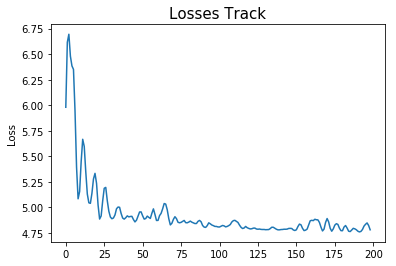

In [24]:
model1.plotLoss()

#### Random normal as the start point

In [25]:
roc_auc_score(y_test,y_hat_2)

0.8575718575718576

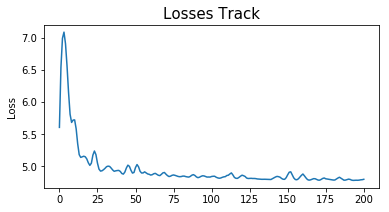

In [26]:
model2.plotLoss()

## Demonstrate the choice of Q0 and Q1 of LinearModel

In [45]:
model1 = easylogistic.LassoClassifierCV(beta_mean=True,Q0=0.95,Q1=0.95)
model1.fit(X_origin,y_test)
model2 = easylogistic.LassoClassifierCV(beta_mean=True,Q0=1,Q1=1)
model2.fit(X_origin,y_test)
y_hat_1 = model1.predict_proba(X_origin)[:,1]
y_hat_2 = model2.predict_proba(X_origin)[:,1]

CV loop No.0 for lambda=0.1
2019-08/19/19 15:28:47	40	5.812038
2019-08/19/19 15:28:47	60	4.873815
2019-08/19/19 15:28:47	80	5.351536
2019-08/19/19 15:28:47	100	5.27214
CV loop No.1 for lambda=0.1
2019-08/19/19 15:28:47	40	5.7619224
2019-08/19/19 15:28:47	60	5.55916
2019-08/19/19 15:28:47	80	5.2403994
2019-08/19/19 15:28:47	100	5.7208843
CV loop No.0 for lambda=0.01
2019-08/19/19 15:28:48	40	5.3318048
2019-08/19/19 15:28:48	60	5.1892867
CV loop No.1 for lambda=0.01
2019-08/19/19 15:28:48	40	5.6438212
2019-08/19/19 15:28:48	60	4.994979
2019-08/19/19 15:28:48	80	5.1978135
2019-08/19/19 15:28:49	100	5.4976954
CV loop No.0 for lambda=0.001
2019-08/19/19 15:28:49	40	5.229802
2019-08/19/19 15:28:49	60	5.124355
2019-08/19/19 15:28:49	80	5.2072487
2019-08/19/19 15:28:49	100	5.0109468
CV loop No.1 for lambda=0.001
2019-08/19/19 15:28:50	40	5.5456934
2019-08/19/19 15:28:50	60	5.137891
CV loop No.0 for lambda=0.0001
2019-08/19/19 15:28:50	40	5.713598
2019-08/19/19 15:28:50	60	5.057001
2019-08/19/1

#### Q0 and Q1 less than 1

which means the largest (1-Q0)*100% elements with label Y=0 and (1-Q1)*100% elements with label Y=1, before taking the mean

In [46]:
roc_auc_score(y_test,y_hat_1)

0.87001287001287

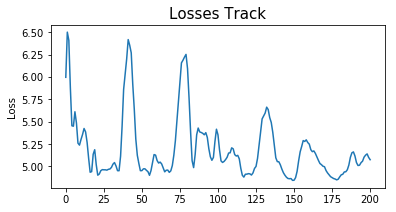

In [47]:
model1.plotLoss()

#### Q0 and Q1 equal to 1

In [48]:
roc_auc_score(y_test,y_hat_2)

0.8537108537108536

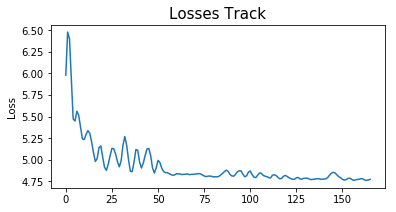

In [49]:
model2.plotLoss()